<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Feature%20Selection/Model_based_and_sequential_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel # based on an estimator that provide feature importance in the form of coef_ or feature_importance
from sklearn.feature_selection import SequentialFeatureSelector  # based on greedy approach
from sklearn.linear_model import RidgeCV


## Introduction

Lets compares two approaches for feature selection: `SelectFromModel` which is based on feature importance, and `SequentialFeatureSelection` which relies on a greedy approach.

We use the Diabetes dataset, which consists of 10 features collected from 442 diabetes patients.

## Load the data

In [4]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

In [7]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

## Feature importance from coefficients

To get an idea of the importance of the features, we are going to use the `RidgeCV` estimator. 

The features with the highest absolute coef_ value are considered the most important.

We can observe the coefficients directly without needing to scale them because from the description above, we know that the features were already standardized. 

In [19]:
alphas = np.logspace(-10,10,20)
ridge = RidgeCV(alphas=alphas)
ridge.fit(X,y)

RidgeCV(alphas=array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10]))

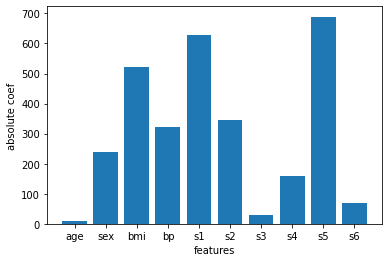

In [20]:
abs_coef = np.abs(ridge.coef_)
plt.bar(diabetes.feature_names, abs_coef);
plt.xlabel('features')
plt.ylabel('absolute coef');

## Selecting features based on importance
Now we want to select the two features which are the most important according to the coefficients. The SelectFromModel is meant just for that. SelectFromModel accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

Since we want to select only 2 features, we will set this threshold slightly above the coefficient of third most important feature.

In [21]:
threshold = np.sort(abs_coef)[-3]

In [23]:
selector = SelectFromModel(estimator=ridge, threshold=threshold, max_features=2)
selector.fit(X,y)

SelectFromModel(estimator=RidgeCV(alphas=array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10])),
                max_features=2, threshold=520.7972288352063)

In [38]:
# lets see which features are selected
print(f"Features selected by SelectFromModel: { [diabetes.feature_names[i]  for i,j in enumerate(selector.get_support()) if j==True]}")


Features selected by SelectFromModel: ['s1', 's5']


## Selecting features with Sequential Feature Selection

Another way of selecting features is to use SequentialFeatureSelector (SFS). SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based on the cross-validation score.

We start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

We can also go in the reverse direction (backward SFS), i.e. start with all the features and greedily choose features to remove one by one. 

In [39]:
%%time

forward = SequentialFeatureSelector(estimator=ridge, n_features_to_select=2, direction='forward')
forward.fit(X,y)

CPU times: user 451 ms, sys: 0 ns, total: 451 ms
Wall time: 463 ms


In [40]:
%%time

backward = SequentialFeatureSelector(estimator=ridge, n_features_to_select=2, direction='backward')
backward.fit(X,y)

CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 1.4 s


In [43]:
# lets see which features are selected by Sequential feature selection [ forward ]
print(f"Features selected by Sequential feature selection [ forward ]: { [diabetes.feature_names[i]  for i,j in enumerate(forward.support_) if j==True]}")

Features selected by Sequential feature selection [ forward ]: ['bmi', 's5']


In [44]:
# lets see which features are selected by Sequential feature selection [ backward ]
print(f"Features selected by Sequential feature selection [ backward ]: { [diabetes.feature_names[i]  for i,j in enumerate(backward.support_) if j==True]}")

Features selected by Sequential feature selection [ backward ]: ['bmi', 's5']


Interestingly, forward and backward selection have selected the same set of features. In general, this isn’t the case and the two methods would lead to different results.

We also note that the features selected by SFS differ from those selected by feature importance: SFS selects bmi instead of s1. This does sound reasonable though, since bmi corresponds to the third most important feature according to the coefficients. It is quite remarkable considering that SFS makes no use of the coefficients at all.

To finish with, we should note that SelectFromModel is significantly faster than SFS. Indeed, SelectFromModel only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations. SFS however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute. The forward SFS is faster than the backward SFS because it only needs to perform n_features_to_select = 2 iterations, while the backward SFS needs to perform n_features - n_features_to_select = 8 iterations.